## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remain the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [28]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [ ]:
# Random state seed
rseed = 42

## Load and explore data

In [30]:
# Import the dataset
try:
    df = pd.read_csv('Country-data.csv')
except FileNotFoundError:
    print('Data file not found.')

In [31]:
# Check the shape
df.shape

(167, 10)

In [ ]:
# Check datatypes & counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [33]:
# Get descriptive statistics
df.describe().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.80,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


In [34]:
# Identify any missing data
print(df.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [ ]:
try:
    df_x_countries = df.drop('country', axis=1)
    print("Column removed.")
except KeyError:
    print("Column previously removed.")

Column removed.


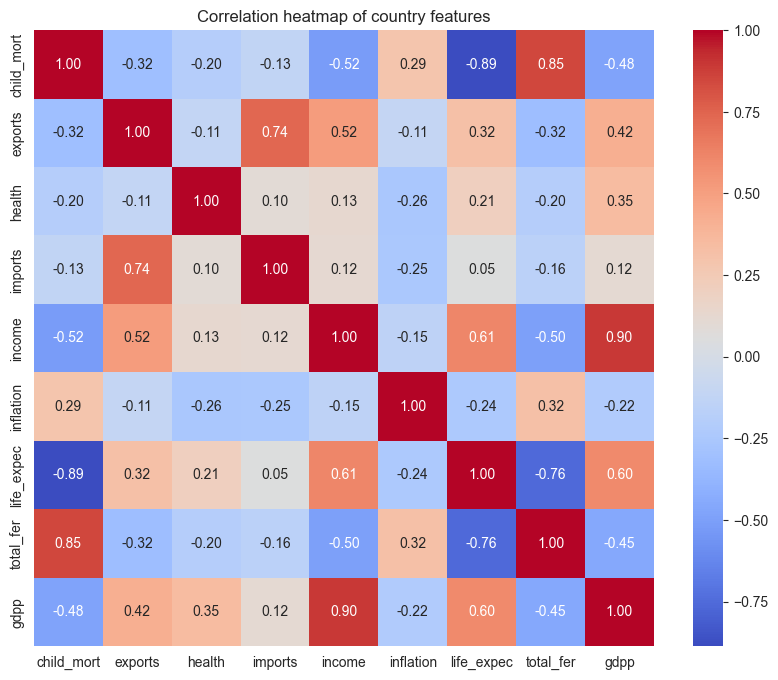

In [36]:
# Create a correlation map of features to explore relationships between features
corr_matrix = df_x_countries.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap of country features')
plt.show()

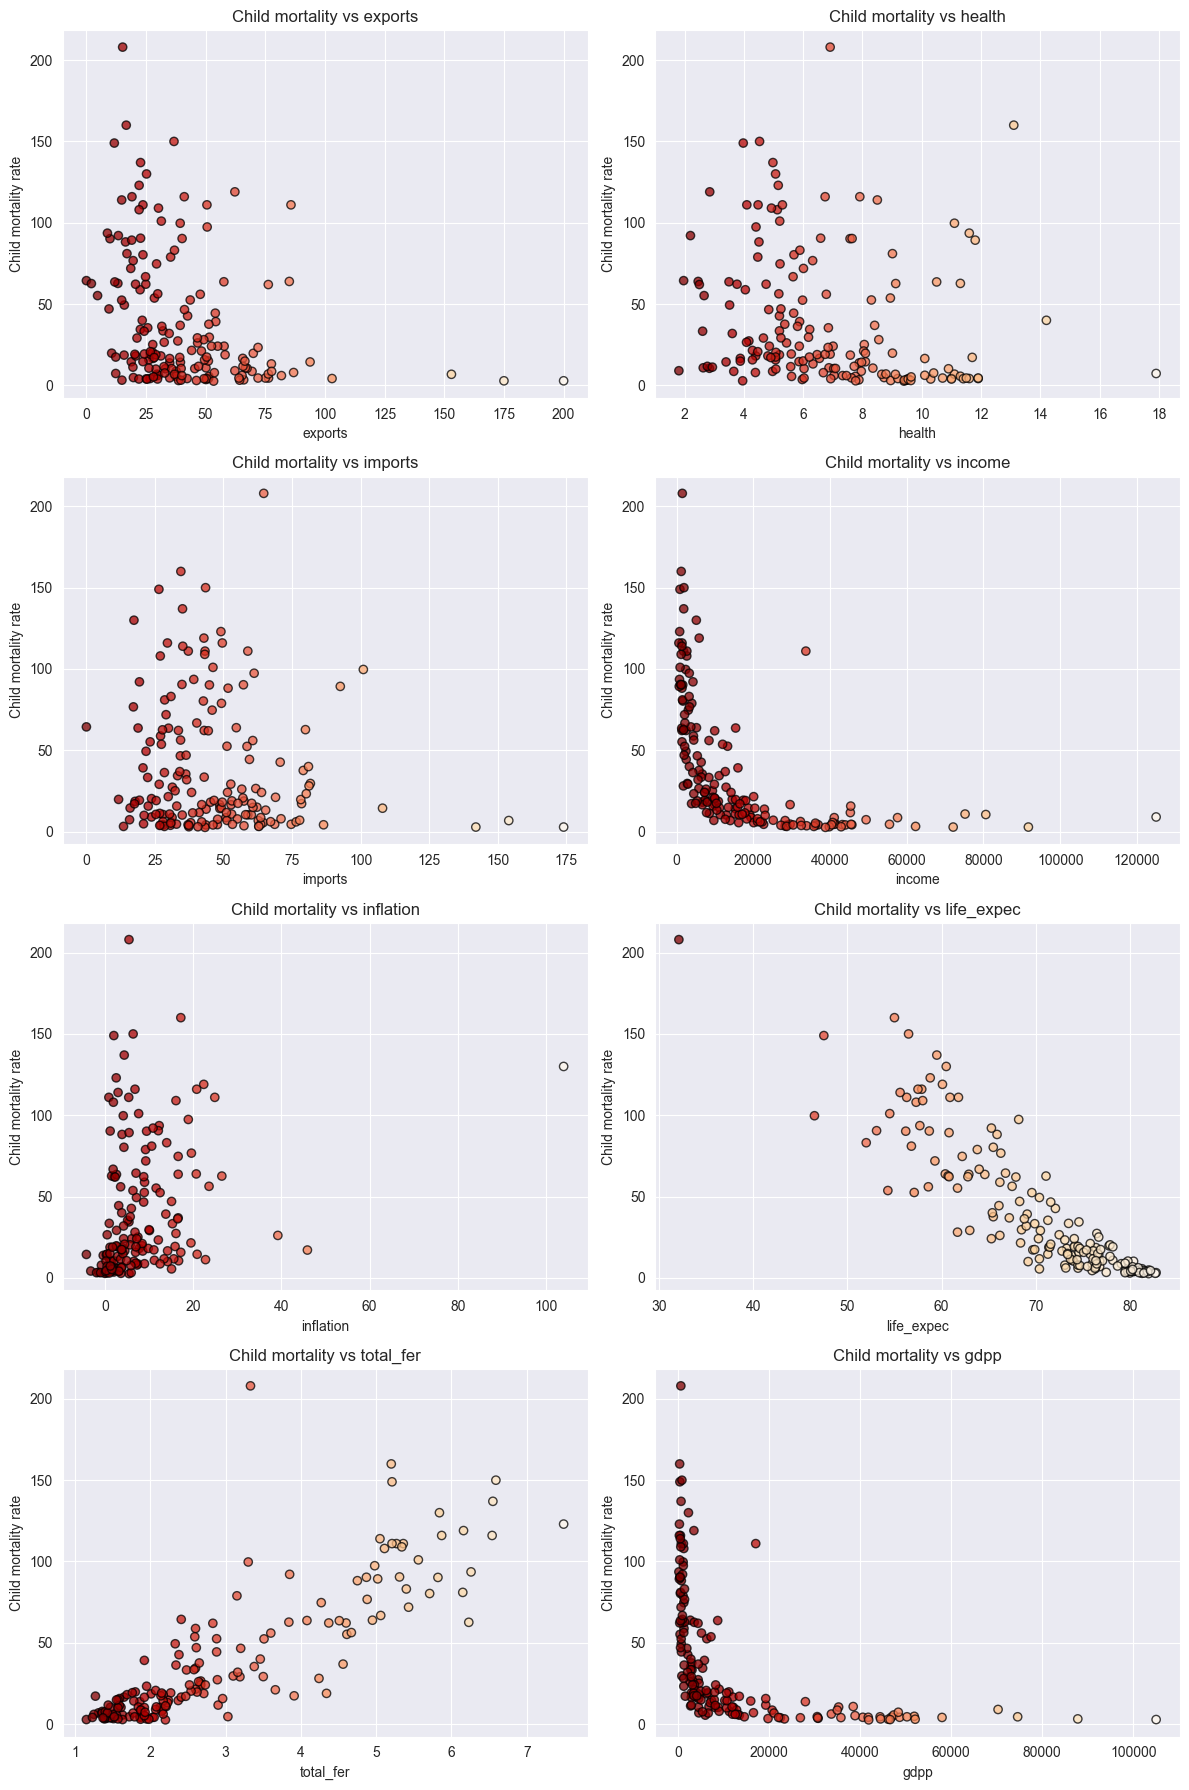

In [ ]:
# Explore the continuous independent features against child_mort using scatter plots.

features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Setting the stying of Seaborn figures
sns.set_style('darkgrid')

# Grid of subplots: 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 18))  

for i, feature in enumerate(features):
    row = i // 2   # Subplot row number
    col = i % 2    # Subplot col number
    ax = axes[row, col]
    sc = ax.scatter(
        df_x_countries[feature],
        df_x_countries['child_mort'],
        c=df[feature],
        cmap='OrRd_r',
        edgecolor='k',
        alpha=0.75
    )
    ax.set_title(f'Child mortality vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Child mortality rate')


plt.tight_layout()
plt.show()


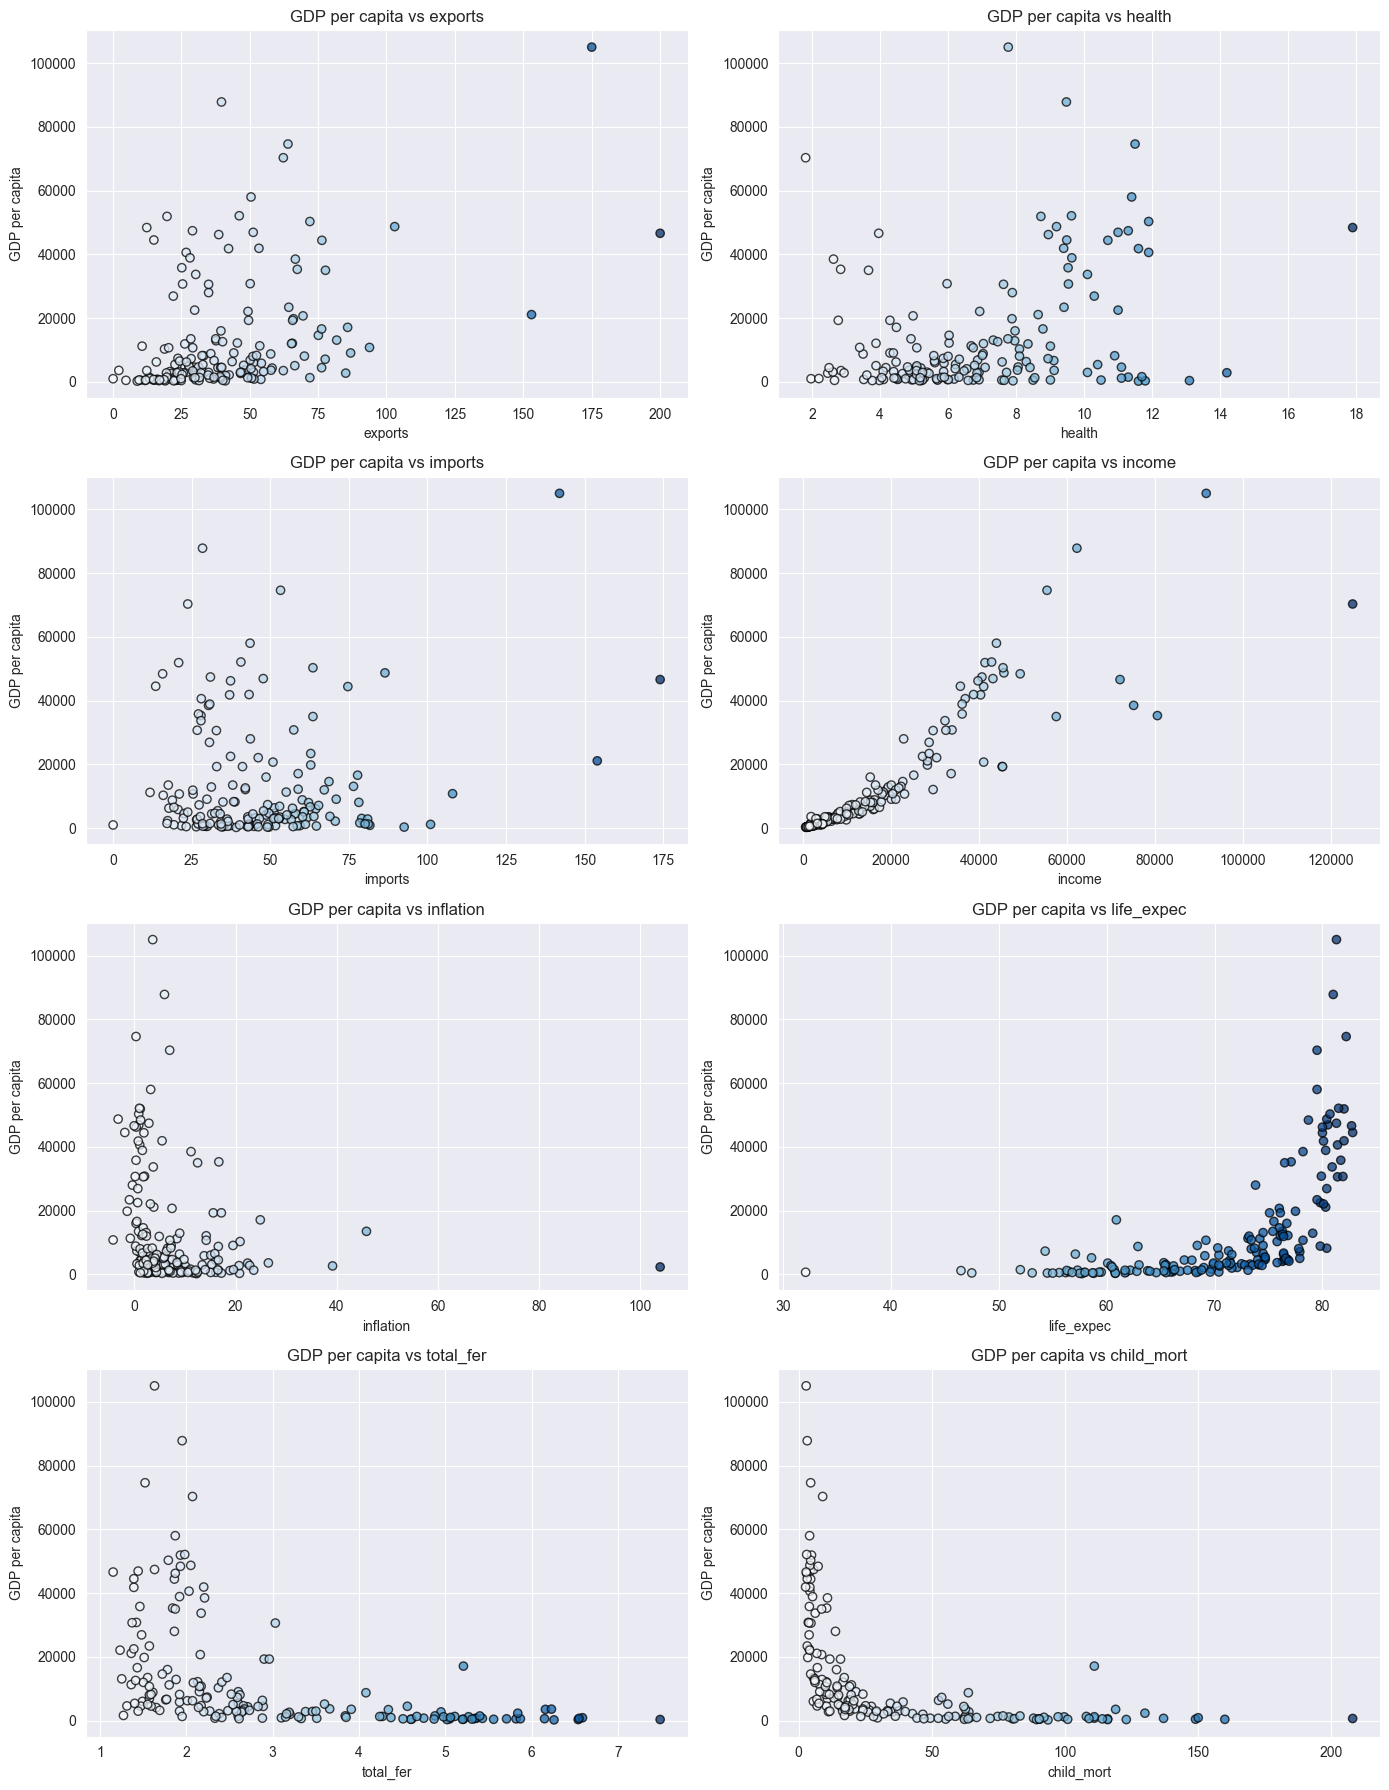

In [ ]:
# Explore the continuous independent features against gdpp using scatter plots.

features_2 = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'child_mort']

fig, axes = plt.subplots(4, 2, figsize=(14, 18))  

for i, feature in enumerate(features_2):
    row = i // 2   
    col = i % 2    
    ax = axes[row, col]
    sc = ax.scatter(
        df_x_countries[feature],
        df_x_countries['gdpp'],
        c=df_x_countries[feature],
        cmap='Blues',  
        edgecolor='k',
        alpha=0.75
    )
    ax.set_title(f'GDP per capita vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('GDP per capita')

plt.tight_layout()
plt.show()

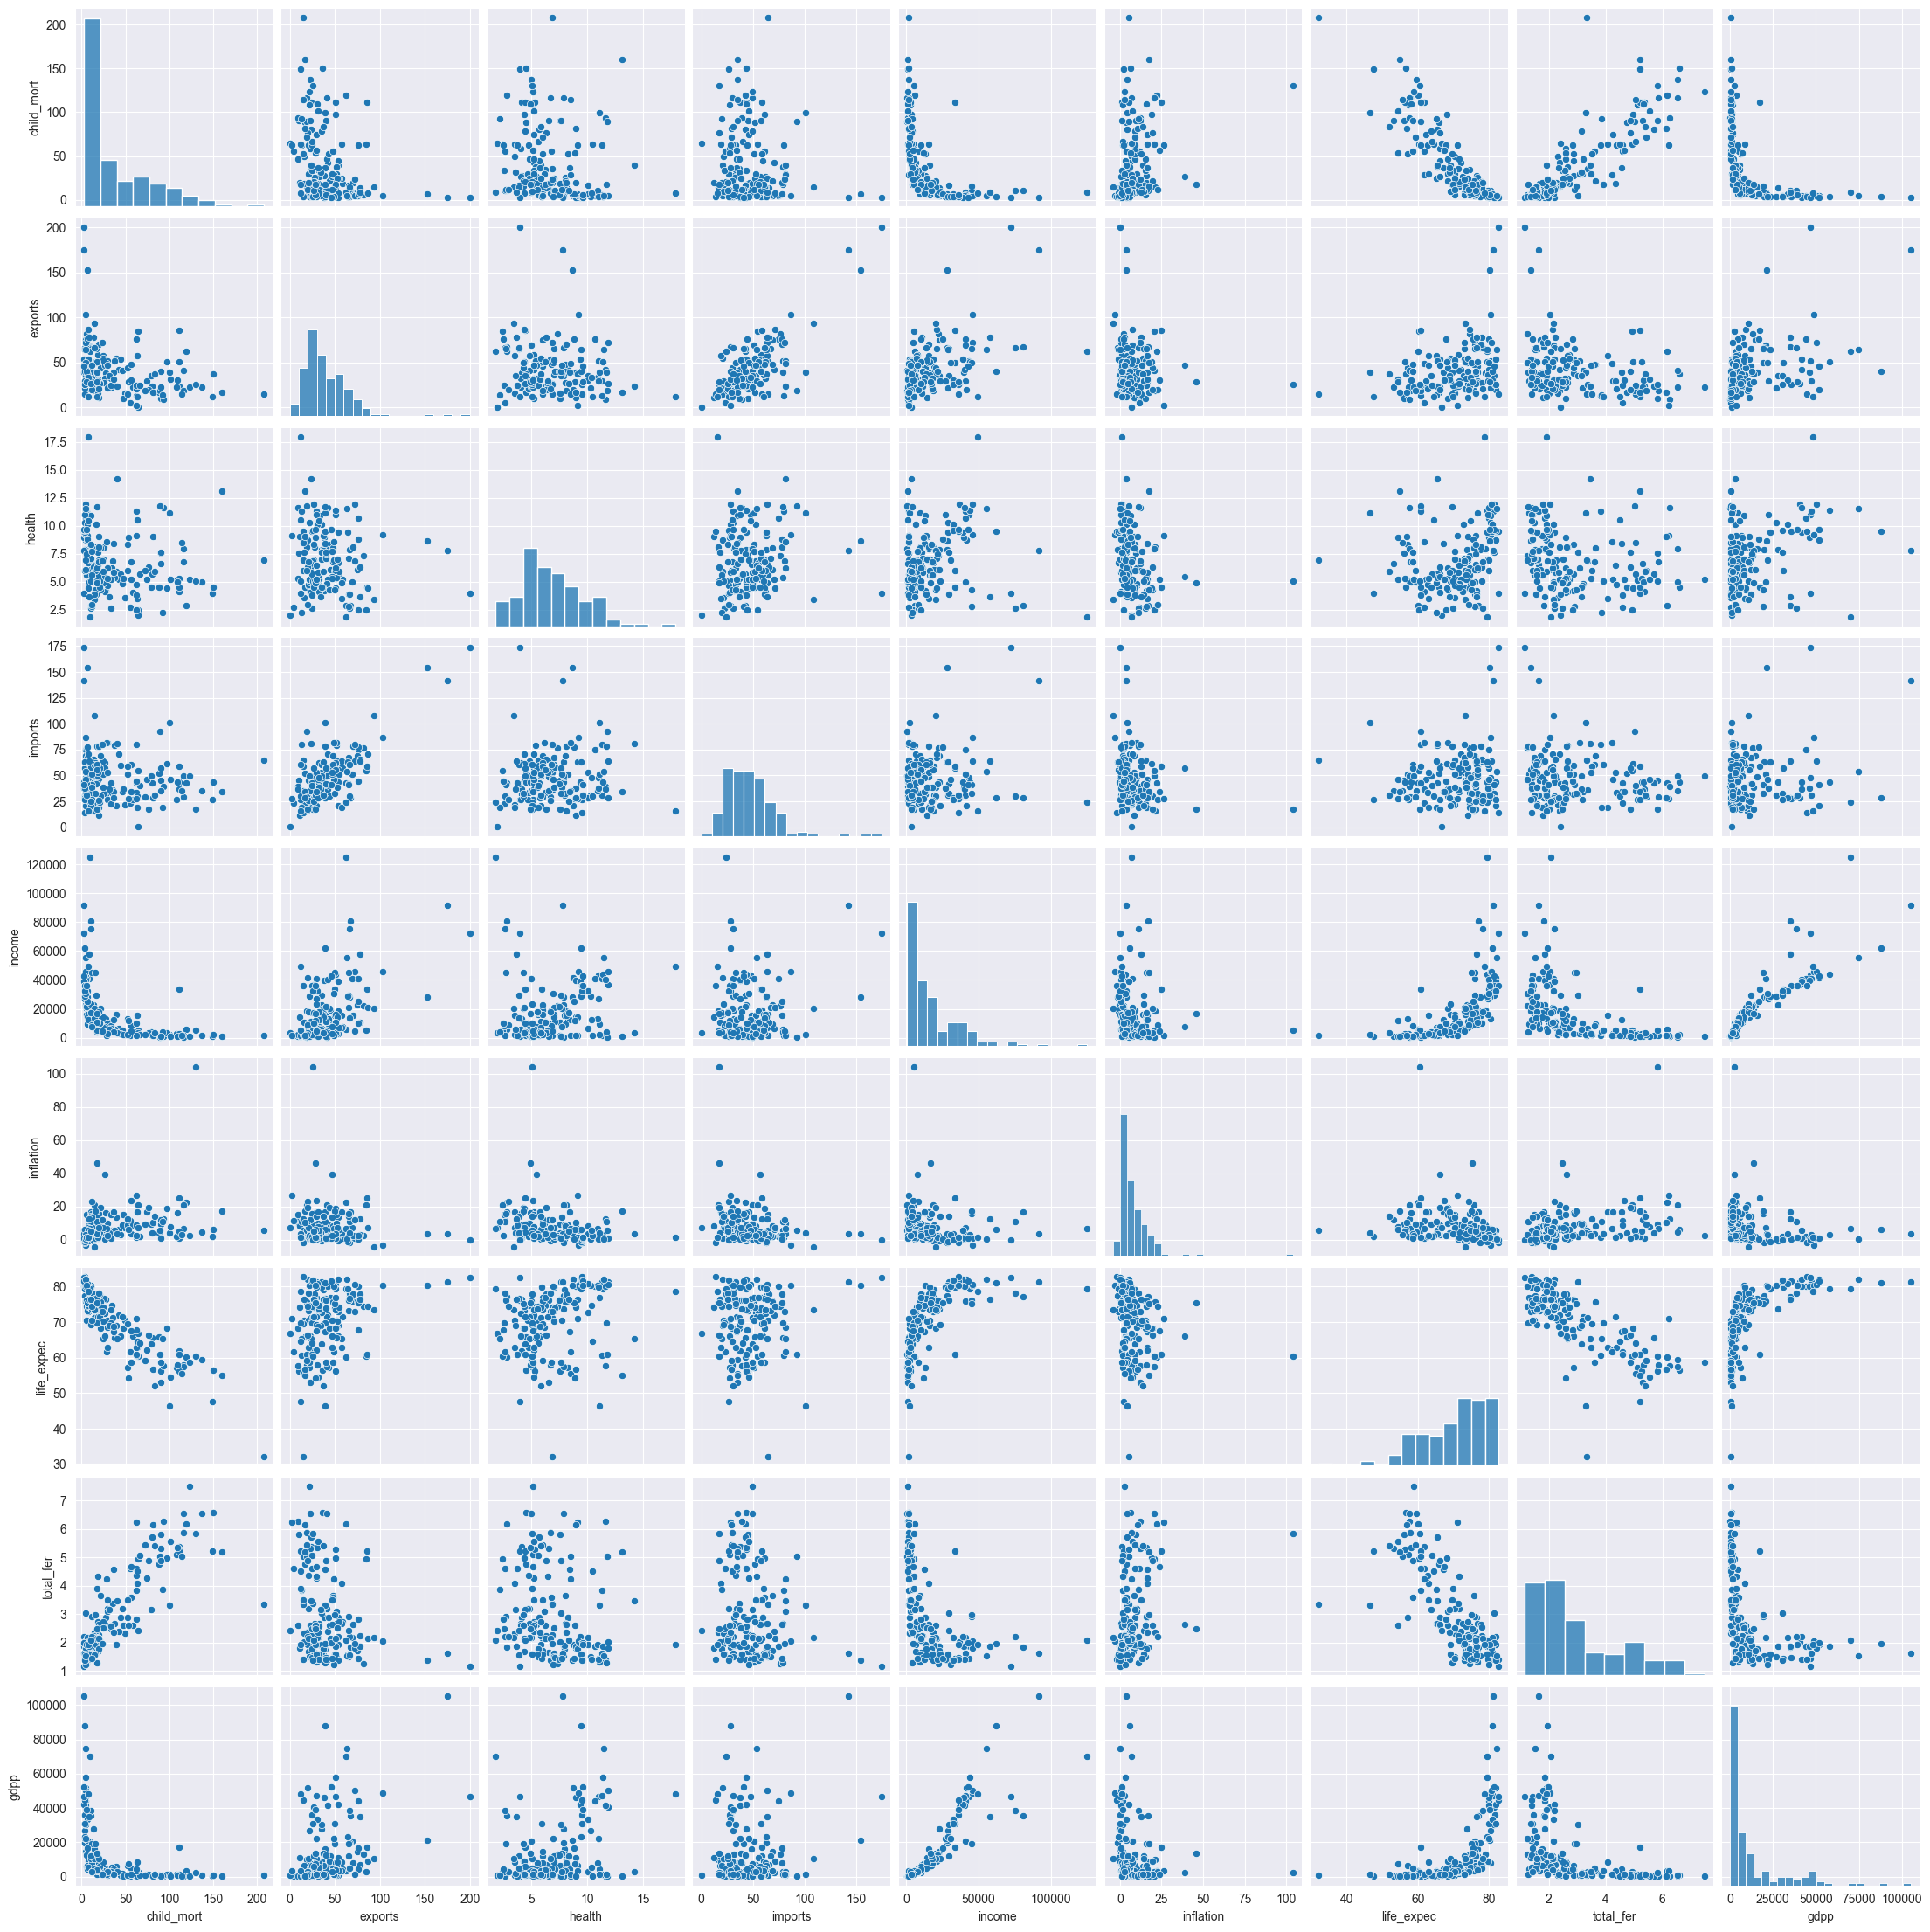

In [39]:
# Create a pair plot
sns.pairplot(df_x_countries)
plt.show()

Creating a pair plot is a helpful step in exploring the relationships between features before clustering data. The diagonal plots within a pair plot show the distribution of individual features, which can give insight into how the data is spread for each feature. While distinct peaks in these plots may hint at features with distinct ranges, true separability is better assessed by examining the off-diagonal plots, which show the relationships between pairs of features. These relationships provide a clearer view of how well the data might separate into clusters.

### Scaling the Data

In [40]:
# Normalise the data using MinMaxScaler and rename dataframe

scaled_data = MinMaxScaler().fit_transform(df_x_countries)
df_scaled = pd.DataFrame(scaled_data, columns=df_x_countries.columns, index=df_x_countries.index)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

In [ ]:
def eval_Kmeans(x, k, r):
    """
    Evaluates the KMeans clustering for a given number of clusters (k)
    and random seed (r), returning the inertia (sum of squared distances
    of samples to their closest cluster center).

    Parameters:
    - x: Data to be clustered.
    - k: Number of clusters.
    - r: Random state for reproducibility.

    Returns:
    - inertia: Sum of squared distances within clusters.
    """
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    """
    Plots the inertia (within-cluster variance) against the number of
    clusters to help determine the optimal number of clusters (the 'elbow' point).

    Parameters:
    - x: Data to be clustered.
    - max_k: Maximum number of clusters to evaluate (default is 10).
    - r: Random state for reproducibility (default is 123).
    """
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

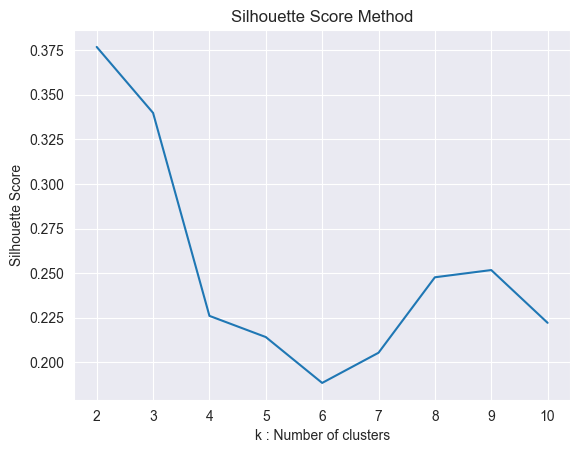

In [42]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [43]:
# Fitting K-means model

X = df_scaled[['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'child_mort']]

k_values = range(5, 10)

# Fit model for each k value
kmeans_models = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=rseed)
    kmeans.fit(X)
    kmeans_models[k] = kmeans

In [44]:
# Count the number of observations in each cluster

# Add cluster col
df_cluster = df_scaled.copy()
df_cluster['cluster'] = kmeans.labels_  

# Count observations
for k, model in kmeans_models.items():
    labels = model.labels_
    
    # Observations by cluster
    counts = pd.Series(labels).value_counts().sort_index()
    
    print(f'\nCluster counts for k = {k}:')
    print(counts)


Cluster counts for k = 5:
0    55
1    43
2    10
3    26
4    33
Name: count, dtype: int64

Cluster counts for k = 6:
0    26
1    37
2     6
3    28
4    26
5    44
Name: count, dtype: int64

Cluster counts for k = 7:
0    26
1    37
2     6
3    27
4    26
5    42
6     3
Name: count, dtype: int64

Cluster counts for k = 8:
0    46
1    45
2    37
3    20
4     4
5     7
6     6
7     2
Name: count, dtype: int64

Cluster counts for k = 9:
0    46
1    45
2    36
3    20
4     4
5     7
6     6
7     2
8     1
Name: count, dtype: int64


In [45]:
# Check model performance with silhouette coefficient

for k in range(5, 10):
    kmeans = KMeans(n_clusters=k, random_state=rseed)  
    kmeans.fit(df_cluster)
    labels = kmeans.labels_
    print(f'Silhouette coefficient for k = {k}: {silhouette_score(df_cluster, labels):.3f}')

Silhouette coefficient for k = 5: 0.675
Silhouette coefficient for k = 6: 0.681
Silhouette coefficient for k = 7: 0.684
Silhouette coefficient for k = 8: 0.690
Silhouette coefficient for k = 9: 0.702


## Predictions

## Visualisation of clusters

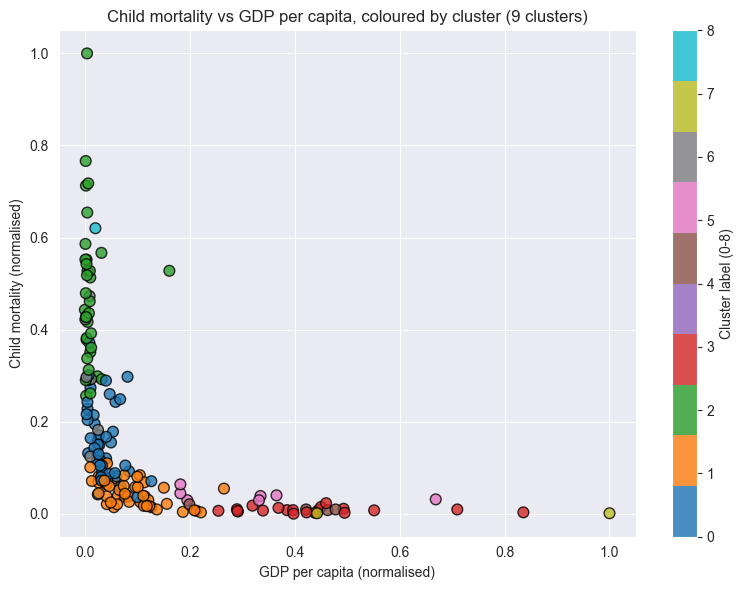

In [ ]:
# Visualisation of clusters: child mortality vs gdpp

kmeans = KMeans(n_clusters=9, random_state=42)  
kmeans.fit(df_cluster) 
labels = kmeans.labels_  

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    df_cluster['gdpp'],
    df_cluster['child_mort'],
    c=df_cluster['cluster'],
    cmap='tab10',
    edgecolor='k',
    s=60,
    alpha=0.8
)

plt.xlabel('GDP per capita (normalised)')
plt.ylabel('Child mortality (normalised)')
plt.title('Child mortality vs GDP per capita, coloured by cluster (9 clusters)')
plt.colorbar(scatter, label='Cluster label (0-8)')
plt.tight_layout()
plt.show()


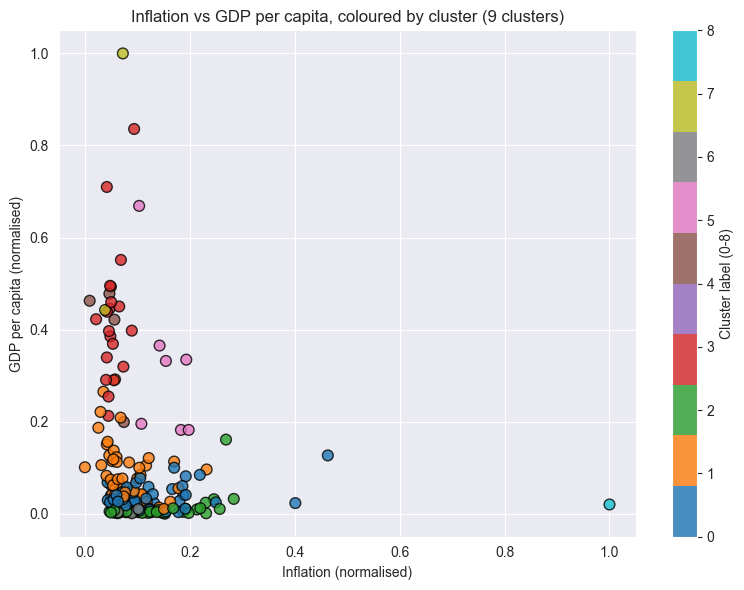

In [ ]:
# Visualisation of clusters: inflation vs gdpp

kmeans = KMeans(n_clusters=9, random_state=42)  
kmeans.fit(df_cluster) 
labels = kmeans.labels_  

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    df_cluster['inflation'],
    df_cluster['gdpp'],
    c=df_cluster['cluster'],
    cmap='tab10',
    edgecolor='k',
    s=60,
    alpha=0.8
)

plt.xlabel('Inflation (normalised)')
plt.ylabel('GDP per capita (normalised)')
plt.title('Inflation vs GDP per capita, coloured by cluster (9 clusters)')
plt.colorbar(scatter, label='Cluster label (0-8)')
plt.tight_layout()
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


In [114]:
# Split countries by cluster and income level
income_labels = ['Low-income', 'Lower middle-income', 'Upper middle-income', 'High-income']
df_cluster['income_group'] = pd.qcut(
    df_cluster['income'], 
    q=4, 
    labels=income_labels
)

# Add back country names col to the dataframe and select median examples by income group
df_cluster['country'] = df['country']

example_countries = []

for group in df_cluster['income_group'].unique():
    group_data = df_cluster[df_cluster['income_group'] == group]
    median_income = group_data['income'].median()
    
    # Country closest to median income as example
    closest = group_data.iloc[(group_data['income'] - median_income).abs().argsort()[:1]]
    example_countries.append(closest)

label_df = pd.concat(example_countries)

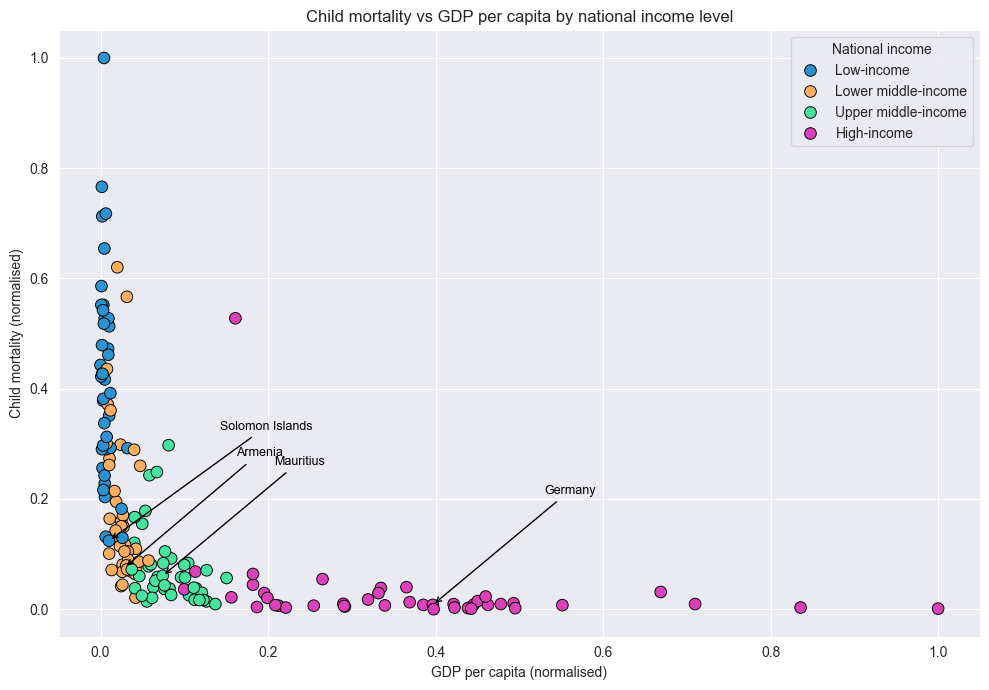

In [115]:
palette = {
    'Low-income': "#2c92d1", 
    'Lower middle-income': '#fdae61', 
    'Upper middle-income': "#47e3a0", 
    'High-income': "#dc42b8"
}

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_cluster,
    x='gdpp',
    y='child_mort',
    hue='income_group',
    palette=palette,
    s=70,
    edgecolor='k'
)

# Annotate countries
for _, row in label_df.iterrows():
    plt.annotate(
        text=row['country'], 
        xy=(row['gdpp'], row['child_mort']),
        textcoords='offset points',         
        xytext=(80, 80),                     
        ha='left',                          
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=9,
        color="#000000"
    )

plt.title('Child mortality vs GDP per capita by national income level')
plt.xlabel('GDP per capita (normalised)')
plt.ylabel('Child mortality (normalised)')
plt.legend(title='National income')
plt.tight_layout()
plt.show()

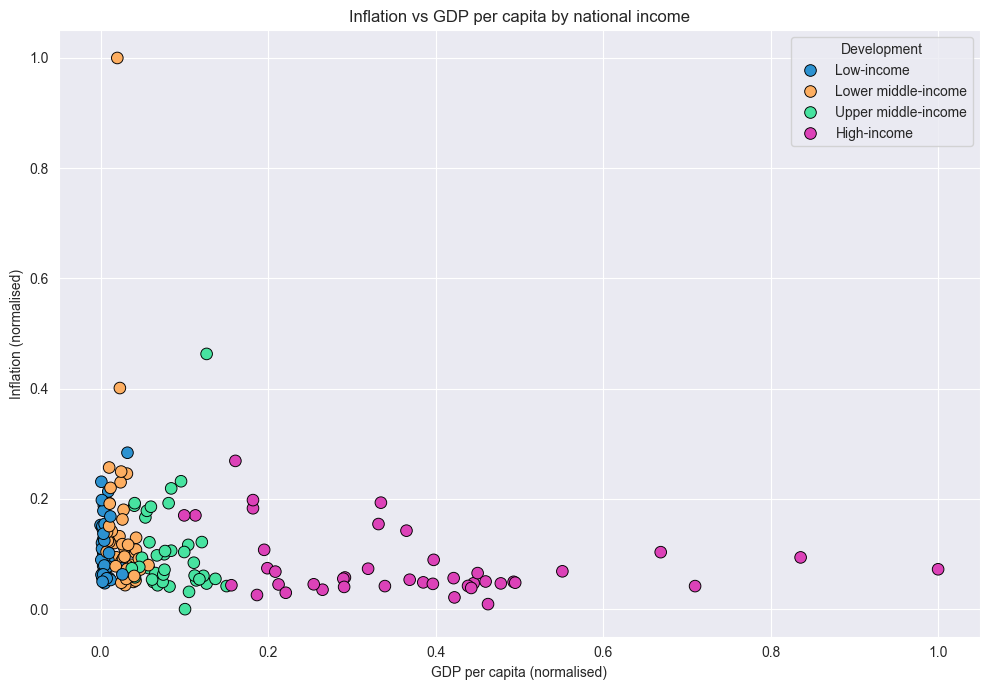

In [109]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_cluster,
    x='gdpp',
    y='inflation',
    hue='income_group',
    palette=palette,
    s=70,
    edgecolor='k'
)

plt.title('Inflation vs GDP per capita by national income')
plt.xlabel('GDP per capita (normalised)')
plt.ylabel('Inflation (normalised)')
plt.legend(title='Development')
plt.tight_layout()
plt.show()

Grouping the countries by national income level showed a much better clustering compared to GDP per capita. The income groups are more defined and can be linked to a median example, as shown in the figure above for Child mortality vs GDP per capita by national income level.